In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [58]:
def read_data(test, train):
    X_test = test.drop(columns=['highGrade'])
    labels_test = test['highGrade']

    X_train = train.drop(columns=['highGrade'])
    labels_train = train['highGrade']

    return X_train, X_test, labels_train, labels_test


In [59]:
df = pd.read_csv('processedFlair.csv')
sorted_columns = sorted(df.columns)
df=df[sorted_columns]
X= df.drop(columns=['highGrade'])
y = df['highGrade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

'''df_true = df[df['highGrade'] == True]
df_false = df[df['highGrade'] == False]

test_size = int(0.2 * len(df))
half_test_size = test_size // 2

test_true = df_true.sample(n=half_test_size, random_state=42)
test_false = df_false.sample(n=half_test_size, random_state=42)

df_test = ptest_false = df_false.sample(n=half_test_size, random_state=42)

df_test = pd.concat([test_true, test_false])

df_training = df.drop(df_test.index)

print("DATASET TRAINING: ", len(df_training), " REGISTROS")

print("DATASET TESTING: ", len(df_test), " REGISTROS")'''

'df_true = df[df[\'highGrade\'] == True]\ndf_false = df[df[\'highGrade\'] == False]\n\ntest_size = int(0.2 * len(df))\nhalf_test_size = test_size // 2\n\ntest_true = df_true.sample(n=half_test_size, random_state=42)\ntest_false = df_false.sample(n=half_test_size, random_state=42)\n\ndf_test = ptest_false = df_false.sample(n=half_test_size, random_state=42)\n\ndf_test = pd.concat([test_true, test_false])\n\ndf_training = df.drop(df_test.index)\n\nprint("DATASET TRAINING: ", len(df_training), " REGISTROS")\n\nprint("DATASET TESTING: ", len(df_test), " REGISTROS")'

In [60]:
#print('Fraction of positive labels:', str(round(100*np.mean(labels_train),3)) + '%')

In [61]:
def get_precisions_recalls(actual, preds):
    plt.figure(figsize=(16,4))

    plt.subplot(1,2,1)
    precision_0 = np.sum((actual == 0) & (preds == 0)) / np.sum(preds == 0)
    precision_1 = np.sum((actual == 1) & (preds == 1)) / np.sum(preds == 1)

    plt.bar([0,1], [precision_0, precision_1])
    plt.xticks([0,1], ['Class 0', 'Class 1'], fontsize=20)
    plt.yticks(np.arange(0,1.1,0.1), fontsize=14)
    plt.ylabel('Precision', fontsize=20)
    plt.title(f'Precision Class 0: {round(precision_0,2)}\nPrecision Class 1: {round(precision_1,2)}', fontsize=20)

    plt.subplot(1,2,2)
    recall_0 = np.sum((actual == 0) & (preds == 0)) / np.sum(actual == 0)
    recall_1 = np.sum((actual == 1) & (preds == 1)) / np.sum(actual == 1)

    plt.bar([0,1], [recall_0, recall_1])
    plt.xticks([0,1], ['Class 0', 'Class 1'], fontsize=20)
    plt.yticks(np.arange(0,1.1,0.1), fontsize=14)
    plt.ylabel('Recall', fontsize=20)
    plt.title(f'Recall Class 0: {round(recall_0,2)}\nRecall Class 1: {round(recall_1,2)}', fontsize=20)

    plt.tight_layout()
    plt.show()

## Data cleaning

In [62]:
'''df = pd.read_csv('flair_df.csv')

# Detectar columnas con un único valor
constant_columns = [col for col in df.columns if df[col].nunique() == 1]

# Mostrar columnas detectadas
print("Columnas con valor constante:")
print(constant_columns)'''

'df = pd.read_csv(\'flair_df.csv\')\n\n# Detectar columnas con un único valor\nconstant_columns = [col for col in df.columns if df[col].nunique() == 1]\n\n# Mostrar columnas detectadas\nprint("Columnas con valor constante:")\nprint(constant_columns)'

In [63]:
# Eliminar esas columnas del DataFrame
#df_filtered = df.drop(columns=constant_columns)
#columns_to_delete = ['Hash/Mask-original/diagnostics', 'Hash/Image-original/diagnostics']
df_filtered = df

# Guardar dataset limpio (opcional)
#df_filtered.to_csv('radiomics_features_no_constant.csv', index=False)

# Confirmar tamaño nuevo del dataset
print(f"Dataset original: {df.shape[1]} columnas")
print(f"Dataset limpio: {df_filtered.shape[1]} columnas")

Dataset original: 122 columnas
Dataset limpio: 122 columnas


In [64]:
print(list(df_filtered.columns))

['10Percentile/firstorder/original', '90Percentile/firstorder/original', 'Autocorrelation/glcm/original', 'Busyness/ngtdm/original', 'ClusterProminence/glcm/original', 'ClusterShade/glcm/original', 'ClusterTendency/glcm/original', 'Coarseness/ngtdm/original', 'Complexity/ngtdm/original', 'Contrast/glcm/original', 'Contrast/ngtdm/original', 'Correlation/glcm/original', 'DependenceEntropy/gldm/original', 'DependenceNonUniformity/gldm/original', 'DependenceNonUniformityNormalized/gldm/original', 'DependenceVariance/gldm/original', 'DifferenceAverage/glcm/original', 'DifferenceEntropy/glcm/original', 'DifferenceVariance/glcm/original', 'Energy/firstorder/original', 'Entropy/firstorder/original', 'GrayLevelNonUniformity/gldm/original', 'GrayLevelNonUniformity/glrlm/original', 'GrayLevelNonUniformity/glszm/original', 'GrayLevelNonUniformityNormalized/glrlm/original', 'GrayLevelNonUniformityNormalized/glszm/original', 'GrayLevelVariance/gldm/original', 'GrayLevelVariance/glrlm/original', 'Gra

# Decision Tree

In [65]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(X_train.columns)
preds = clf.predict(X_test)

Index(['10Percentile/firstorder/original', '90Percentile/firstorder/original',
       'Autocorrelation/glcm/original', 'Busyness/ngtdm/original',
       'ClusterProminence/glcm/original', 'ClusterShade/glcm/original',
       'ClusterTendency/glcm/original', 'Coarseness/ngtdm/original',
       'Complexity/ngtdm/original', 'Contrast/glcm/original',
       ...
       'c.BoundingBox/Mask-original/diagnostics',
       'c.CenterOfMass/Mask-original/diagnostics',
       'c.CenterOfMassIndex/Mask-original/diagnostics',
       'c.Size/Image-original/diagnostics', 'c.Size/Mask-original/diagnostics',
       'c.Spacing/Image-original/diagnostics',
       'c.Spacing/Mask-original/diagnostics',
       'd.BoundingBox/Mask-original/diagnostics',
       'e.BoundingBox/Mask-original/diagnostics',
       'f.BoundingBox/Mask-original/diagnostics'],
      dtype='object', length=121)


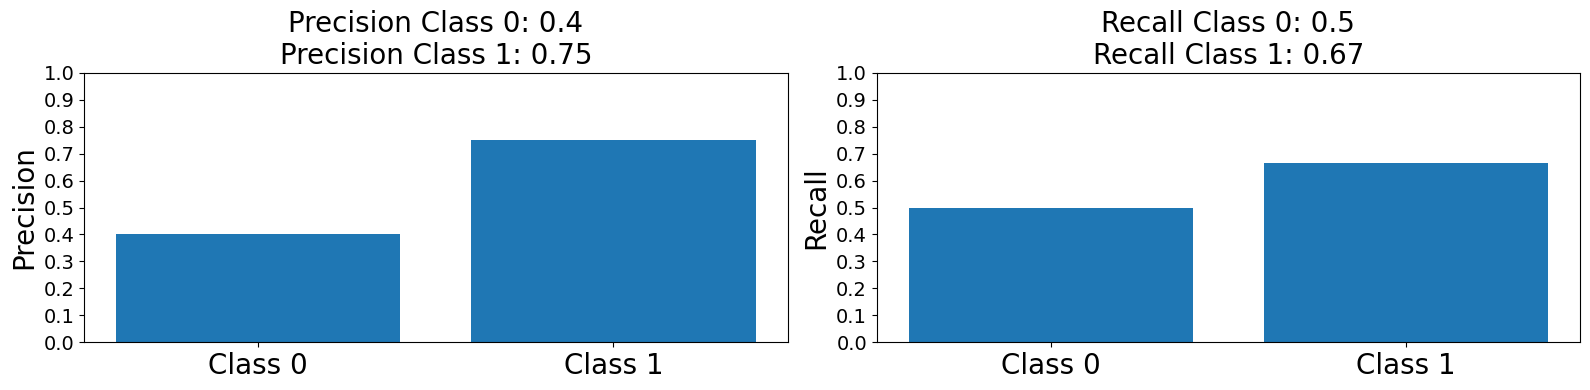

In [66]:
get_precisions_recalls(y_test, preds)

# Upweight the minority class

In [67]:
weight_minority_class = np.sum(y_train == True) / np.sum(y_test == False)

In [68]:
weight_minority_class

10.125

In [69]:
clf = DecisionTreeClassifier(class_weight={0:1, 1:weight_minority_class})
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

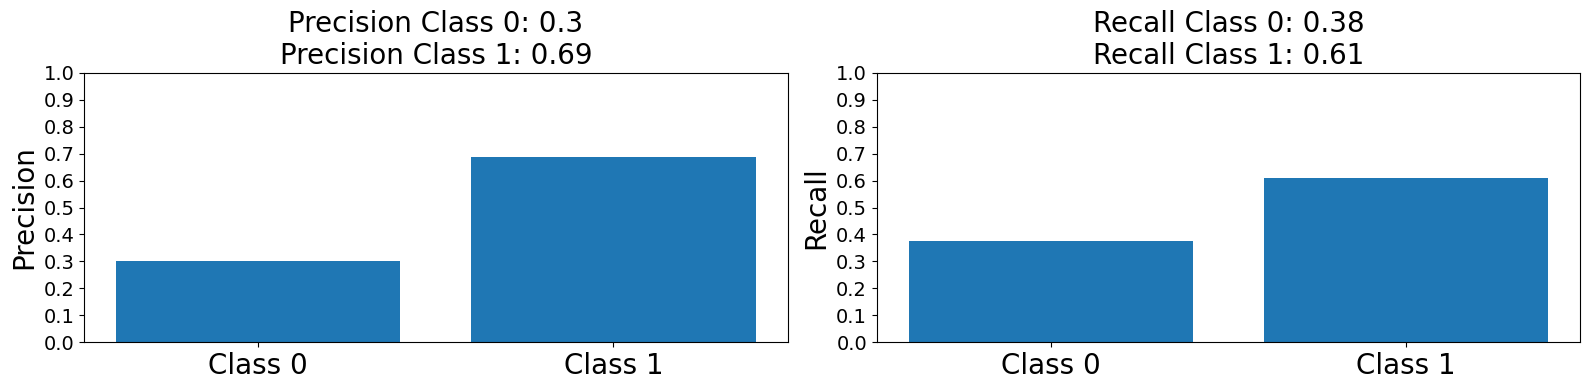

In [70]:
get_precisions_recalls(y_test, preds)

In [71]:
import pickle

with open('decision_tree_model.pkl', 'wb') as f:
    pickle.dump(clf, f)


# Solution 2: Oversample Minority Class

In [72]:
indices_0 = df_training[df_training['highGrade'] == False].index
indices_1 = df_training[df_training['highGrade'] == True].index
indices = indices_0.union(indices_1)


weight_minority_class = len(indices_1) / len(indices_0)


weights_0 = pd.Series(weight_minority_class, index=indices_0)
weights_1 = pd.Series(1.0, index=indices_1)
weights = pd.concat([weights_0, weights_1])
weights = weights / weights.sum()  # Normalizar

sampled_indices = np.random.choice(weights.index, size=len(weights), p=weights.values)


df_oversampled = df_training.loc[sampled_indices]


positive_frac = round(100 * df_oversampled['highGrade'].mean(), 3)
print(f'Fraction of positive labels in oversampled data: {positive_frac}%')
df_oversampled.mean()

NameError: name 'df_training' is not defined

In [ ]:
X_train_oversampled = df_oversampled.drop(columns=['highGrade'])
labels_train_oversampled = df_oversampled['highGrade']

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train_oversampled, labels_train_oversampled)
preds = clf.predict(X_test)

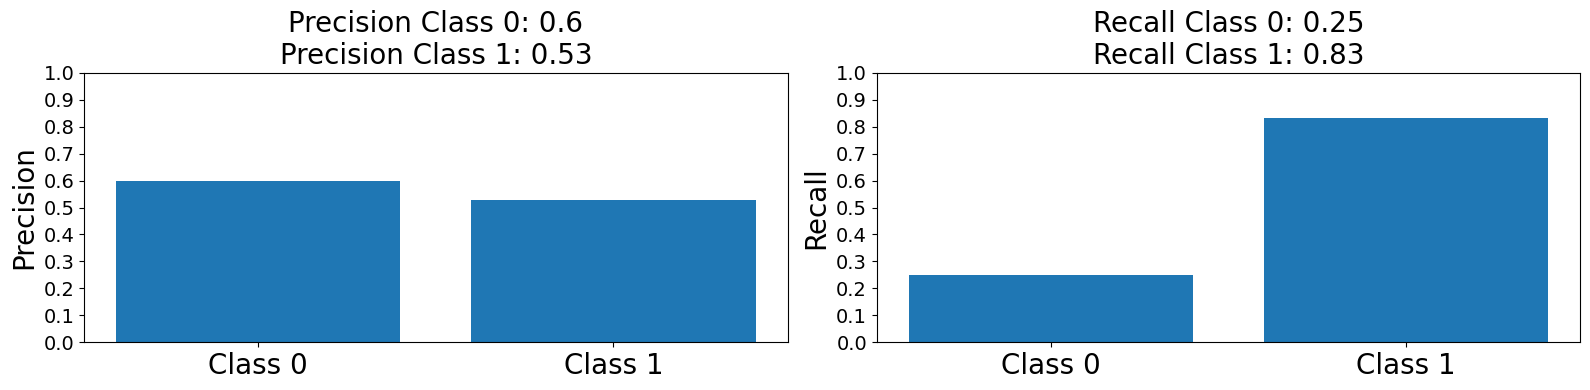

In [ ]:
get_precisions_recalls(labels_test, preds)